2095


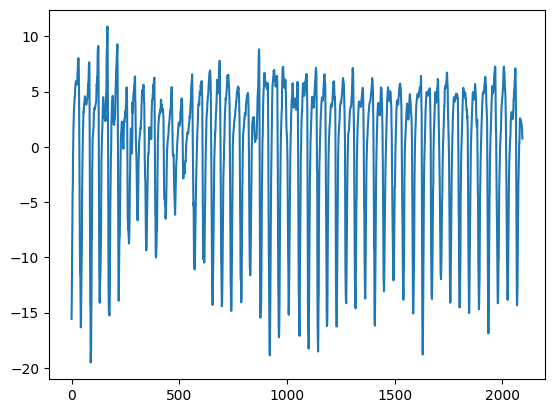

In [63]:
import matplotlib.pyplot as plt

y = []
x = []
with open("/Users/alannon/Documents/Arduino/sampleAccel/hpf.txt") as inFile:
    for idx, line in enumerate(inFile):
        y.append(float(line.strip()))
        x.append(idx)
print(len(y))

plt.plot(x, y)
plt.show()

In [59]:
from scipy import signal
def lpf(samples, freq, sample_rate):
    b, a = signal.cheby1(3, 3, freq, fs=sample_rate, btype='lowpass')
    return signal.lfilter(b, a, samples)

def hpf(samples, freq, sample_rate):
    b, a = signal.cheby1(3, 3, freq, fs=sample_rate, btype='highpass')
    print("hpf coeffs: ", a, b)
    return signal.lfilter(b, a, samples)

hpf coeffs:  [ 1.         -2.94287818  2.88635027 -0.94345706] [ 0.97158569 -2.91475706  2.91475706 -0.97158569]
fft bpm  154.83870967741936


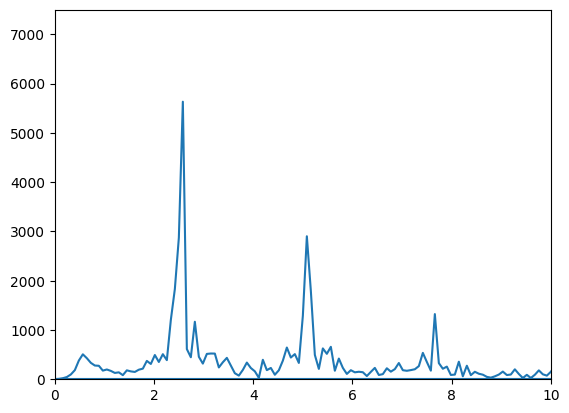

best freq:  2.5641025641025643  power:  16.769529840933526
best bpm: 153.84615384615387


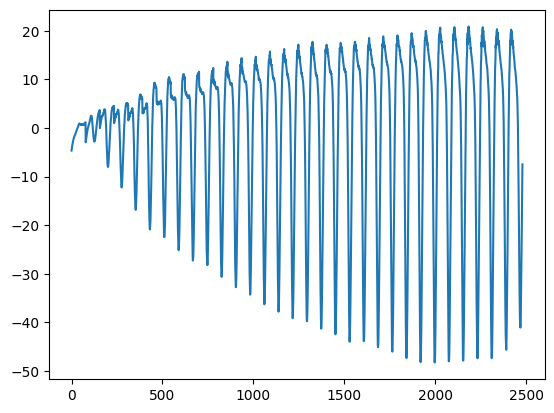

crossings count:  31
[100, 216, 288, 363, 440, 519, 598, 676, 755, 834, 913, 992, 1070, 1148, 1226, 1304, 1382, 1461, 1539, 1617, 1695, 1773, 1851, 1929, 2007, 2084, 2162, 2241, 2319, 2398, 2476]
one_cycle_beat_tempo  153.84615384615387
4 sample beat tempo 152.86624203821654
one_cycle_beat_tempo  148.14814814814815
4 sample beat tempo 148.14814814814815
Zero crossing tempo:  151.5151515151515
Zero crossing unfiltered tempo:  154.118689105403
Phase:  0.05128205128205128
Unfiltered phase:  0.05128205128205128
Adjusted phase:  0.8012820512820513


In [60]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import fft, signal
x = []
y = []
# file  = "/Users/alannon/Documents/Arduino/sampleAccel/sample174bpm-sloppy-200hz.txt"
# file = "/Users/alannon/Documents/Arduino/sampleAccel/sample122bpm-100hz.txt"
file = "/Users/alannon/Documents/Arduino/sampleAccel/sample124bpm-200hz.txt"
# file = "/Users/alannon/Documents/Arduino/sampleAccel/sample_no_signal-200hz.txt"
timestep = 0.005
sample_freq = 1 / timestep
with open(file) as inFile:
    for idx, line in enumerate(inFile):
        val = line.strip()
        if (len(val) > 0):
            y.append(float(line.strip()))
            x.append(idx)

# offset = sum(y) / len(y)
# print("Sum(y): ", sum(y), " len(y):", len(y))
# print(offset)
# y = list(map( lambda n: n - offset, y))
# y = [y[n] - offset for n in range(len(y))]
hp_filtered = hpf(y, 0.5, sample_freq)
y = hp_filtered

fourier = abs(fft.fft(y))
freq = fft.fftfreq(len(y), d = timestep)
max_freq = np.argmax(fourier)
actual_bpm = freq[np.argmax(fourier)]
print("fft bpm ", actual_bpm * 60)

plt.plot(freq, list(fourier))
plt.xlim(0, 10)
plt.ylim(0, 7500)
plt.show()

def find_zero_crossings(samples, is_negative):
    crossings = []
    for i in range(1, len(samples)):
        if is_negative:
            if samples[i - 1] >= 0 and samples[i] < 0:
                crossings.append(i)
        if not is_negative:
            if samples[i - 1] <= 0 and samples[i] > 0:
                crossings.append(i)
    return crossings

def beat_freq_from_zero_crossings(crossings, sample_rate):
    print("one_cycle_beat_tempo ", sample_rate / (crossings[-1] - crossings[-2]) * 60)
    print("4 sample beat tempo", sample_rate / ((crossings[-1] - crossings[-5]) / 4) * 60)
    return sample_rate / ((crossings[-1] - crossings[0]) / (len(crossings) - 1))

def find_candidate_tempos(min, max, sample_rate):
    min_samples = round(sample_rate / (max / 60))
    max_samples = round(sample_rate / (min / 60))
    return [(sample_rate / x ) * 60 for x in range(min_samples, max_samples)]




tempo_candidates = find_candidate_tempos(110, 180, sample_freq)
# print(tempo_candidates)


# tempo_candidates = range(110, 175)
# tempo_candidates = []
# sample_coef = list(set(map( lambda x: round((60/x) / timestep) , tempo_candidates)))
# print(sample_coef)

def find_strength(samples, window_size):
    window = samples[-window_size::1]
    return (sum(abs(window)) / window_size)

def comb_filter(input_samples, sample_freq, filter_freq):
    # set denom coef (a) to -1.0 one filter cycle back
    target_sample_coef_idx = round(sample_freq / filter_freq)
    denom_coefs = [0] * (target_sample_coef_idx + 1)
    # denom_coefs[target_sample_coef_idx] = -1.0
    denom_coefs[target_sample_coef_idx] = -0.9
    # latest sample must be 1.0 for reasons?
    denom_coefs[0] = 1.0
    # numer coef (b) is always just a single coef of 1.0
    # numerator_coefs = [1.0]
    numerator_coefs = [0.5]
    return signal.lfilter(numerator_coefs, denom_coefs, input_samples)
    

def strength_process(input_samples, sample_freq, filter_freq):
    filtered_samples = comb_filter(input_samples, sample_freq, filter_freq)
    strength = find_strength(filtered_samples, round((1 / filter_freq) * sample_freq))
    return (strength, filtered_samples)

strengths = {}
comb_filtered = {}
best_freq = {'frq': 0.0, 'str':0.0, 'samps':[]}

for tempo in tempo_candidates:
    filter_freq = tempo / 60
    strength, filtered = strength_process(y, sample_freq, filter_freq)
    if (strength > best_freq['str']):
        best_freq = {'frq': filter_freq, 'str': strength, 'samps': filtered}

print("best freq: ", best_freq['frq'], " power: ", best_freq['str'])
print("best bpm:", best_freq['frq'] * 60)

plt.plot(x,best_freq['samps'])
plt.show()

lpf_with_comb = lpf(best_freq['samps'], best_freq['frq'] * 1.2, sample_freq)
lpf_only = lpf(y, best_freq['frq'] * 1.2, sample_freq)
x = list(map(lambda x: x / sample_freq, range(0, len(lpf_with_comb))))
zero_crossings = find_zero_crossings(lpf_with_comb, True)
zero_crossings_unfiltered = find_zero_crossings(lpf_only, True)
print("crossings count: ", len(zero_crossings))
print(zero_crossings)
# Phase is the proportion of a full cycle the last zero crossing occurred at
phase = (len(lpf_with_comb) - zero_crossings[-1]) / (sample_freq / best_freq['frq'])
unfiltered_phase = (len(lpf_only) - zero_crossings_unfiltered[-1] / (sample_freq / best_freq['frq']))
zero_crossing_freq = beat_freq_from_zero_crossings(zero_crossings, sample_freq)
zero_crossing_freq_unfiltered = beat_freq_from_zero_crossings(zero_crossings_unfiltered, sample_freq)
print("Zero crossing tempo: ", zero_crossing_freq * 60)
print("Zero crossing unfiltered tempo: ", zero_crossing_freq_unfiltered * 60)
# Phase adjusted back 0.25 cycles to get the 'bottom' of the beat
adjusted_phase = phase - 0.25
if (adjusted_phase < 0):
    adjusted_phase += 1.0
print("Phase: ", phase)
print("Unfiltered phase: ", phase)
print("Adjusted phase: ", adjusted_phase)
# plot_fft(comb_filtered[best_strength_freq], sample_freq, "Comb Filter")
# plot_fft(lpf_with_comb, sample_freq, "Comb Filter + LPF")
# plt.plot(x, comb_filtered[best_strength_freq])
# plt.title("Comb Filter")
# plt.show()
# plt.plot(x, lpf_only)
# plt.xlim(0)
# plt.ylim(-200, 200)
# plt.title("LPF")
# plt.show()



-8.899064439140826
actual_bpm  137.47016706443915
2.1739130434782608


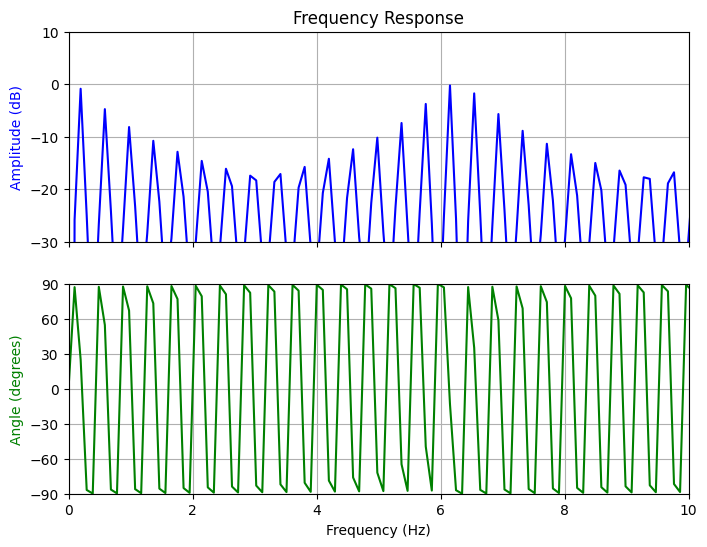

2.1739130434782608


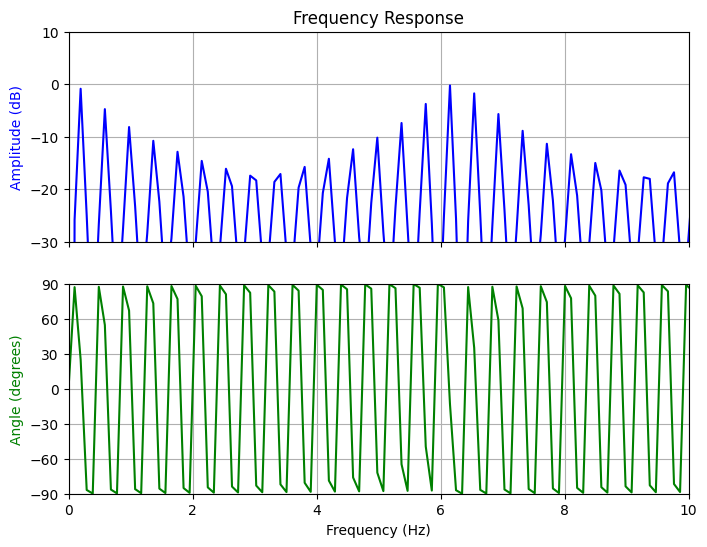

2.2222222222222223


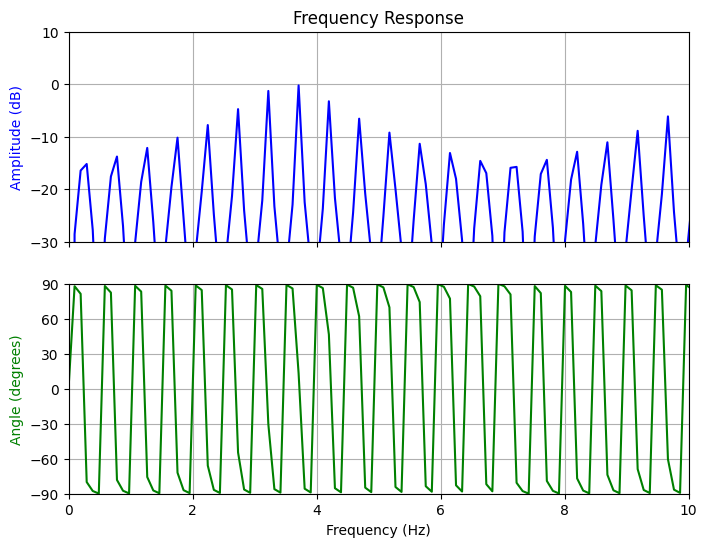

2.2222222222222223


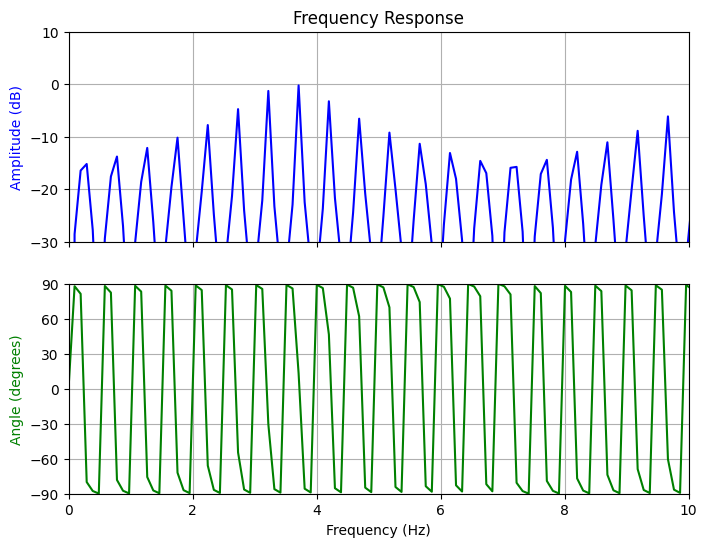

2.2222222222222223


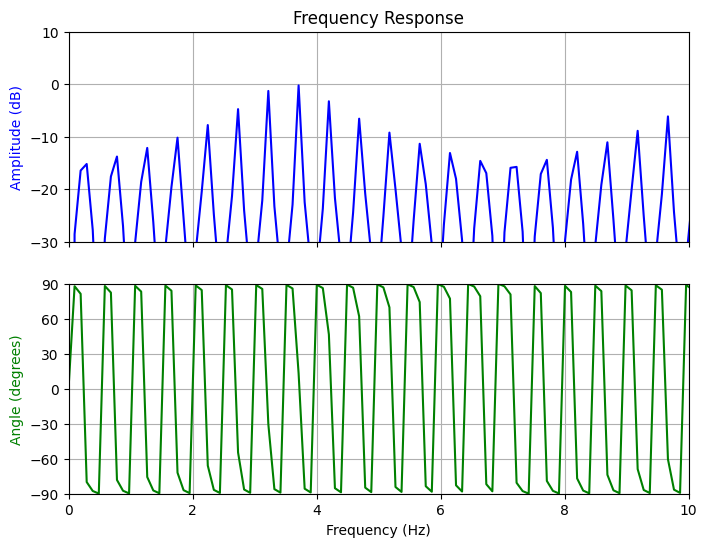

2.272727272727273


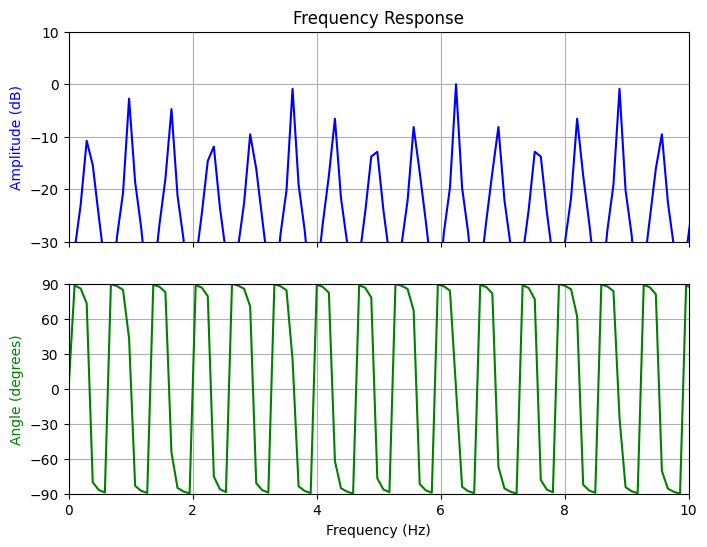

2.272727272727273


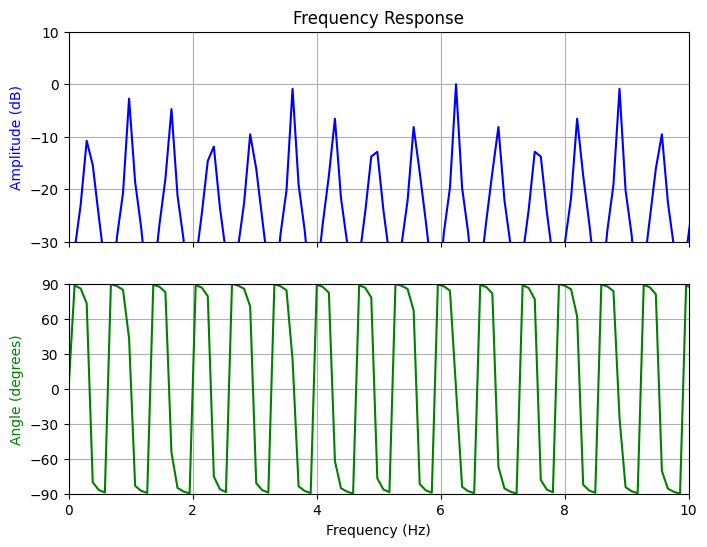

2.272727272727273


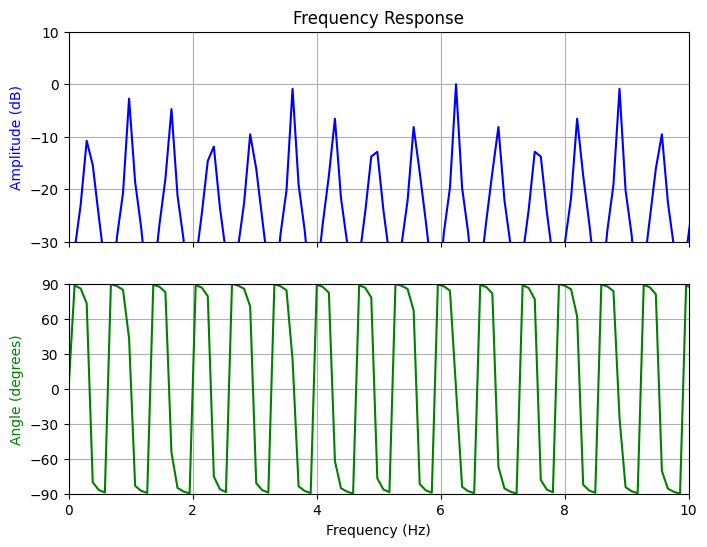

2.3255813953488373


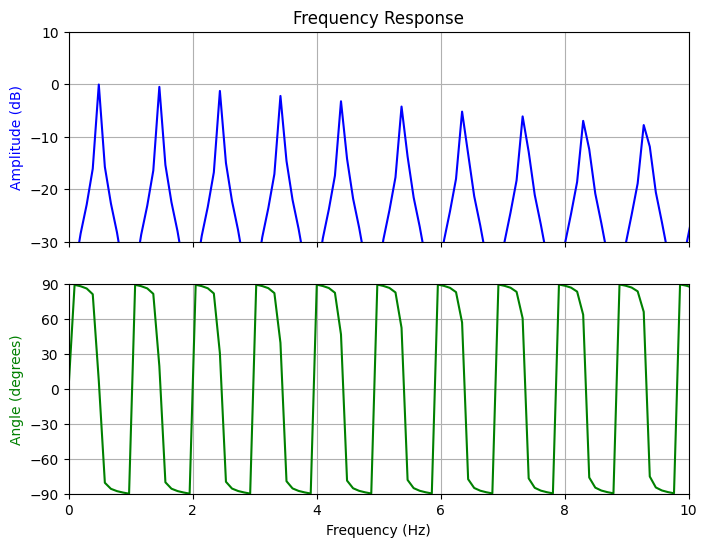

2.3255813953488373


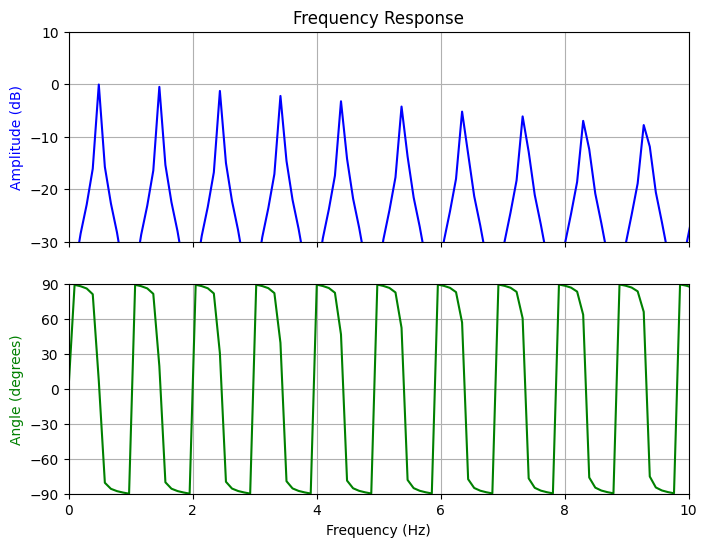

In [83]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import fft, signal
x = []
y = []
with open("/Users/alannon/Documents/Arduino/sampleAccel/sample122bpm-100hz.txt") as inFile:
    for idx, line in enumerate(inFile):
        y.append(float(line.strip()))
        x.append(idx)

offset = sum(y) / len(y)
print(offset)
# y = list(map( lambda n: n - offset, y))
y = [y[n] - offset for n in range(len(y))]

fourier = abs(fft.fft(y))
timestep = 0.01
freq = fft.fftfreq(len(y), d = timestep)
max_freq = np.argmax(fourier)
actual_bpm = freq[np.argmax(fourier)]
print("actual_bpm ", actual_bpm * 60)

def plotfr(b, a, fs):
    freq, h = signal.freqz(b, a, fs=fs)
    response = abs(h)
    # To avoid divide by zero when graphing
    response[response == 0] = 1e-20
    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    ax[0].plot(freq, 20*np.log10(abs(response)), color='blue')
    ax[0].set_title("Frequency Response")
    ax[0].set_ylabel("Amplitude (dB)", color='blue')
    ax[0].set_xlim([0, fs/2])
    ax[0].set_ylim([-30, 10])
    ax[0].grid(True)
    ax[1].plot(freq, (np.angle(h)*180/np.pi+180)%360 - 180, color='green')
    ax[1].set_ylabel("Angle (degrees)", color='green')
    ax[1].set_xlabel("Frequency (Hz)")
    # ax[1].set_xlim([0, fs/2])
    ax[1].set_xlim([0, 10])
    ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax[1].set_ylim([-90, 90])
    ax[1].grid(True)
    plt.show()

tempo_candidates = range(130, 140)
# tempo_candidates = []

for i in range(0, len(tempo_candidates)):
    # freq = round( (1 / (60 / tempo_candidates[i])), 2)
    fs = 1 / timestep
    q_freq = fs * (1 / (round(fs / (tempo_candidates[i] / 60))))
    print(q_freq)
    numerator_coef, denom_coef = signal.iircomb(q_freq * (timestep * 2), 30, 'peak', fs)
    plotfr(numerator_coef, denom_coef, fs)
    # print(denom_coef)
    # filtered = signal.lfilter(numerator_coef, denom_coef, y)
    # plt.title(q_freq * 60)
    # plt.plot(range(0, len(filtered)), filtered)
    # plt.show()
    # print(filtered)


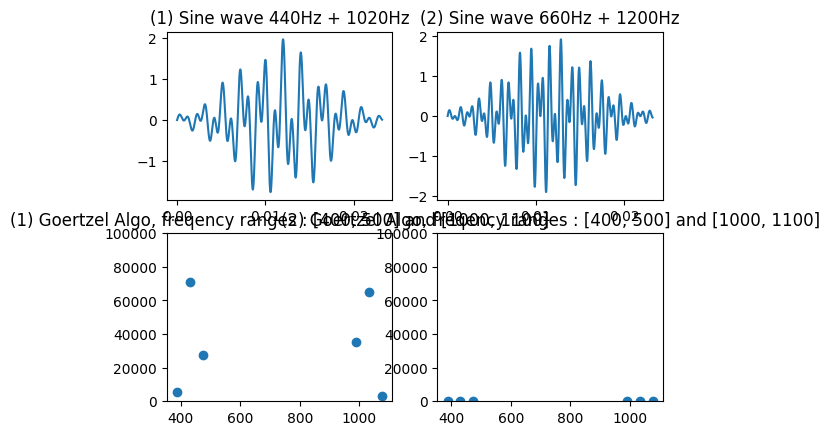

In [79]:
import math

def goertzel(samples, sample_rate, *freqs):
    """
    Implementation of the Goertzel algorithm, useful for calculating individual
    terms of a discrete Fourier transform.
    `samples` is a windowed one-dimensional signal originally sampled at `sample_rate`.
    The function returns 2 arrays, one containing the actual frequencies calculated,
    the second the coefficients `(real part, imag part, power)` for each of those frequencies.
    For simple spectral analysis, the power is usually enough.
    Example of usage :
        
        freqs, results = goertzel(some_samples, 44100, (400, 500), (1000, 1100))
    """
    window_size = len(samples)
    f_step = sample_rate / float(window_size)
    f_step_normalized = 1.0 / window_size

    # Calculate all the DFT bins we have to compute to include frequencies
    # in `freqs`.
    bins = set()
    for f_range in freqs:
        f_start, f_end = f_range
        k_start = int(math.floor(f_start / f_step))
        k_end = int(math.ceil(f_end / f_step))

        if k_end > window_size - 1: raise ValueError('frequency out of range %s' % k_end)
        bins = bins.union(range(k_start, k_end))

    # For all the bins, calculate the DFT term
    n_range = range(0, window_size)
    freqs = []
    results = []
    for k in bins:

        # Bin frequency and coefficients for the computation
        f = k * f_step_normalized
        w_real = 2.0 * math.cos(2.0 * math.pi * f)
        w_imag = math.sin(2.0 * math.pi * f)

        # Doing the calculation on the whole sample
        d1, d2 = 0.0, 0.0
        for n in n_range:
            y  = samples[n] + w_real * d1 - d2
            d2, d1 = d1, y

        # Storing results `(real part, imag part, power)`
        results.append((
            0.5 * w_real * d1 - d2, w_imag * d1,
            d2**2 + d1**2 - w_real * d1 * d2)
        )
        freqs.append(f * sample_rate)
    return freqs, results


if __name__ == '__main__':
    # quick test
    import numpy as np
    import pylab

    # generating test signals
    SAMPLE_RATE = 44100
    WINDOW_SIZE = 1024
    t = np.linspace(0, 1, SAMPLE_RATE)[:WINDOW_SIZE]
    sine_wave = np.sin(2*np.pi*440*t) + np.sin(2*np.pi*1020*t)
    sine_wave = sine_wave * np.hamming(WINDOW_SIZE)
    sine_wave2 = np.sin(2*np.pi*880*t) + np.sin(2*np.pi*1500*t)
    sine_wave2 = sine_wave2 * np.hamming(WINDOW_SIZE)

    # applying Goertzel on those signals, and plotting results
    freqs, results = goertzel(sine_wave, SAMPLE_RATE, (400, 500),  (1000, 1100))

    pylab.subplot(2, 2, 1)
    pylab.title('(1) Sine wave 440Hz + 1020Hz')
    pylab.plot(t, sine_wave)

    pylab.subplot(2, 2, 3)
    pylab.title('(1) Goertzel Algo, freqency ranges : [400, 500] and [1000, 1100]')
    pylab.plot(freqs, np.array(results)[:,2], 'o')
    pylab.ylim([0,100000])

    freqs, results = goertzel(sine_wave2, SAMPLE_RATE, (400, 500),  (1000, 1100))

    pylab.subplot(2, 2, 2)
    pylab.title('(2) Sine wave 660Hz + 1200Hz')
    pylab.plot(t, sine_wave2)

    pylab.subplot(2, 2, 4)
    pylab.title('(2) Goertzel Algo, freqency ranges : [400, 500] and [1000, 1100]')
    pylab.plot(freqs, np.array(results)[:,2], 'o')
    pylab.ylim([0,100000])

    pylab.show()